In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform: #transfer the images from RGB to GreyScale

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
(gs_img, rgb_img), _ = image_dataset[50]  # _ is the image class which we don't need for this assignment
#we don't need label here we are just coloring, and the inputs are 2

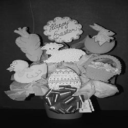

In [ ]:
transforms.functional.to_pil_image(gs_img)

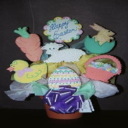

In [ ]:
transforms.functional.to_pil_image(rgb_img)

In [ ]:
print(len(image_dataset))

9144


# Tasks:

1. Build a custo [AutoEncoder] NN model. The input to the model is the Gray Scale Image and it's output should be colored image.
2. Split the data into training and validation splits (80%, 20%). Train the model on training data.
3. After training, show final loss value as well as draw a plot to show how loss dropped during training (both train and val loss).
4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.

In [ ]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            # Input: 1 channel (grayscale)
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), #32 is your choice can be 1, 16
            #nn.BatchNorm2d(32), #no needed we only want to run the code not focusing in high accuracyß
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Outputs 3 channels (RGB) with values in [0, 1]
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded



In [ ]:
#spliting the dataset
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

#data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_loss, val_loss = [], []

    for epoch in range(num_epochs): #our label is rgb_img
        model.train()
        running_loss = 0.0
        for data in train_loader:
            gs_img, rgb_img = data[0]
            gs_img, rgb_img = gs_img.to(device), rgb_img.to(device)

            optimizer.zero_grad()
            outputs = model(gs_img)
            loss = criterion(outputs, rgb_img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_loader))

        #validation , #it's not prediction goal so we don't need an accuracy
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                gs_img, rgb_img = data[0]
                gs_img, rgb_img = gs_img.to(device), rgb_img.to(device)

                outputs = model(gs_img)
                loss = criterion(outputs, rgb_img)
                running_val_loss += loss.item()

        val_loss.append(running_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")

    return train_loss, val_loss

#train the model
train_loss, val_loss = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15, Train Loss: 0.033987610965319305, Val Loss: 0.015980022766723716
Epoch 2/15, Train Loss: 0.014833432290217151, Val Loss: 0.013843826917481834
Epoch 3/15, Train Loss: 0.013276323765192343, Val Loss: 0.012605147147230033
Epoch 4/15, Train Loss: 0.012531195912996064, Val Loss: 0.011936775280226922
Epoch 5/15, Train Loss: 0.011783810704946518, Val Loss: 0.011089543940435195
Epoch 6/15, Train Loss: 0.011265651221670534, Val Loss: 0.010693771379261181
Epoch 7/15, Train Loss: 0.010922726883512476, Val Loss: 0.010639364301259148
Epoch 8/15, Train Loss: 0.010738366741039182, Val Loss: 0.010780668785345966
Epoch 9/15, Train Loss: 0.010468697151088197, Val Loss: 0.010144400635156137
Epoch 10/15, Train Loss: 0.010280014072423396, Val Loss: 0.010103233592135125
Epoch 11/15, Train Loss: 0.010157296085811179, Val Loss: 0.009796974570329848
Epoch 12/15, Train Loss: 0.010038723796606063, Val Loss: 0.009887358302186275
Epoch 13/15, Train Loss: 0.009841524206263863, Val Loss: 0.00945834757695

Final Training Loss:  0.009650109194057144
Final Validation Loss:  0.009350565021279556


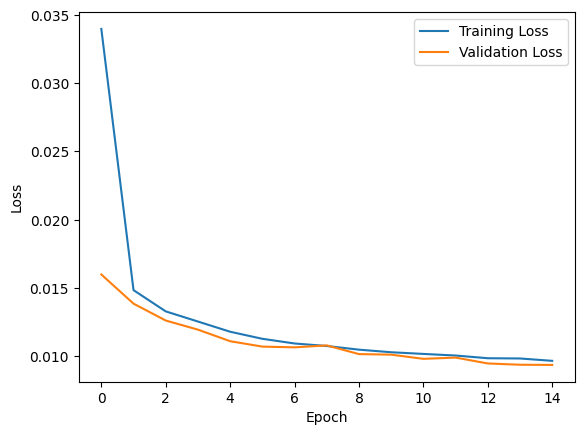

In [ ]:
print('Final Training Loss: ', train_loss[14])
print('Final Validation Loss: ', val_loss[-1])

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def show_images(model, dataset, num_images=3):    #the way we display to see the difference the GreyScale image then original image then output image
    plt.figure(figsize=(12, num_images * 4))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        (gs_img, rgb_img), _ = dataset[idx]

        input_img = gs_img.unsqueeze(0).to(device) # to bring the 1 channel back (1,3,128,128)
        with torch.no_grad():
            output_img = model(input_img)

        output_img = output_img.squeeze(0).cpu()  #this changes shape from [1, 3, 128, 128] to [3, 128, 128]

        gs_img_pil = transforms.functional.to_pil_image(gs_img) #bring back the tensor to an image
        rgb_img_pil = transforms.functional.to_pil_image(rgb_img)
        output_img_pil = transforms.functional.to_pil_image(output_img)

        print(gs_img.shape)
        plt.subplot(num_images, 3, i*3+1)
        plt.imshow(gs_img_pil, cmap='gray')
        plt.title("Grayscale Image")
        plt.axis('off')

        print(rgb_img.shape)
        plt.subplot(num_images, 3, i*3+2)
        plt.imshow(rgb_img_pil)
        plt.title("Original RGB Image")
        plt.axis('off')

        print(output_img.shape) #to check that it is RGB
        plt.subplot(num_images, 3, i*3+3)
        plt.imshow(output_img_pil)
        plt.title("Model Output Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


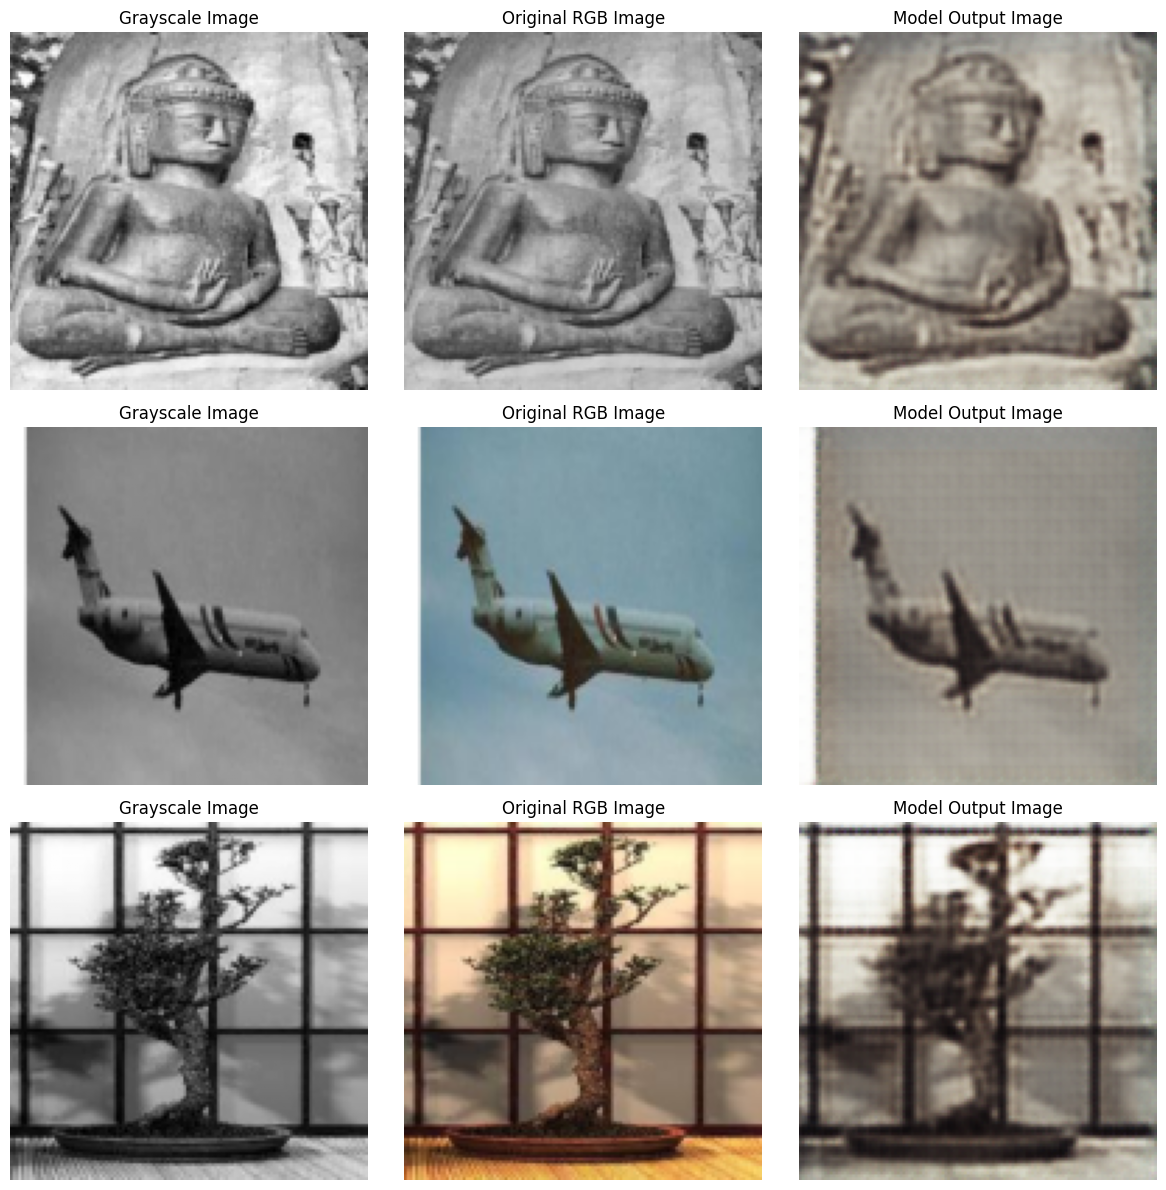

In [ ]:
show_images(model, val_dataset, num_images=3)
